Mounted at /content/drive
Path '/content/drive/MyDrive/' telah ditambahkan ke sistem.

Memuat model terbaik dari: /content/drive/MyDrive/DATASET/model_terbaik.h5


Model berhasil dimuat.

Membaca peta data final dan mempersiapkan data uji...
Ditemukan 25 pasien di set data uji.

Melakukan evaluasi pada data uji...
7/7 ━━━━━━━━━━━━━━━━━━━━ 52s 4s/step - accuracy: 0.8627 - loss: 0.3881 - precision: 0.6308 - recall: 0.8750

--- HASIL EVALUASI DASAR ---
Loss pada Data Uji: 0.3648
Akurasi pada Data Uji: 88.00%
Presisi pada Data Uji: 0.7273
Recall pada Data Uji: 1.0000

Membuat prediksi untuk laporan detail...
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step

LAPORAN KLASIFIKASI AKHIR
                                precision    recall  f1-score   support

Tidak Perlu Adaptasi (Kelas 0)       1.00      0.82      0.90        17
      Perlu Adaptasi (Kelas 1)       0.73      1.00      0.84         8

                      accuracy                           0.88        25
                     macro avg       0.86      0.91      0.87        25
                  weighted avg       0.91      0.88      0.88        25


CONFUSION MATRIX
Penjelasan:
           Prediksi 0 

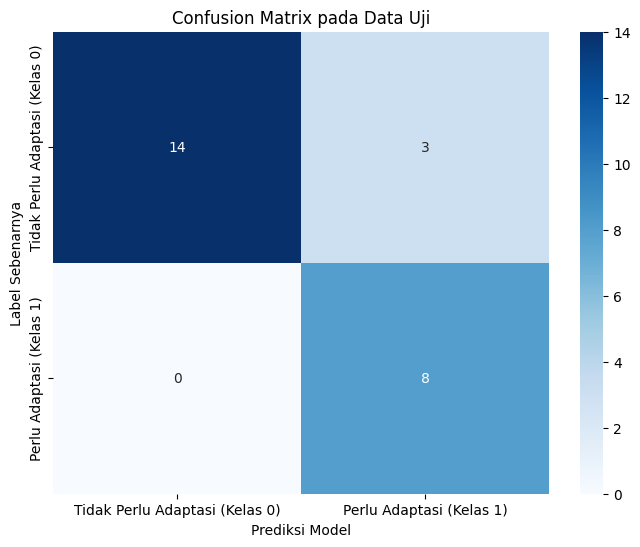


--- PENGUJIAN SELESAI ---


In [ ]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from google.colab import drive
import sys
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- KONFIGURASI ---
# Path ke data (sama seperti saat pelatihan)
DRIVE_BASE_PATH = "/content/drive/MyDrive/"

# --- PERUBAHAN DI SINI ---
# Path sekarang menunjuk langsung ke folder hasil di Google Drive Anda
PATH_HASIL_PELATIHAN = os.path.join(DRIVE_BASE_PATH, "DATASET/")
PATH_MODEL_TERBAIK = os.path.join(PATH_HASIL_PELATIHAN, "model_terbaik.h5")

PATH_PETA_FINAL = os.path.join(DRIVE_BASE_PATH, "DATASET/peta_data_final_fix.csv")
PATH_DATASET_OLAHAN = os.path.join(DRIVE_BASE_PATH, "DATASET/")

# Parameter yang SAMA PERSIS dengan saat pelatihan
UKURAN_BATCH = 4
UKURAN_GAMBAR = (128, 128, 64, 1)

if __name__ == "__main__":
    # 1. Hubungkan Drive dan siapkan path
    drive.mount('/content/drive')
    if DRIVE_BASE_PATH not in sys.path:
        sys.path.append(DRIVE_BASE_PATH)
    print(f"Path '{DRIVE_BASE_PATH}' telah ditambahkan ke sistem.")

    # Impor komponen dari file final
    # Pastikan file komponen_cnn_final.py ada di DRIVE_BASE_PATH
    from cnn_components_final import build_pure_cnn_model, create_image_only_dataset

    # 2. Muat Model Terbaik Anda
    print("\n" + "="*50)
    print(f"Memuat model terbaik dari: {PATH_MODEL_TERBAIK}")
    if not os.path.exists(PATH_MODEL_TERBAIK):
        print("\nERROR: File model_terbaik.h5 tidak ditemukan!")
        print(f"Pastikan folder '{os.path.basename(PATH_HASIL_PELATIHAN)}' ada di dalam Google Drive Anda.")
    else:
        model = tf.keras.models.load_model(PATH_MODEL_TERBAIK)
        print("Model berhasil dimuat.")

        # 3. Siapkan Dataset Uji
        print("\nMembaca peta data final dan mempersiapkan data uji...")
        df = pd.read_csv(PATH_PETA_FINAL)
        list_uji = df[df['Set'] == 'Uji'][['ID_Pasien', 'Grup']].values.tolist()

        if not list_uji:
            print("ERROR: Tidak ada data uji yang ditemukan di peta_data_final.csv")
        else:
            print(f"Ditemukan {len(list_uji)} pasien di set data uji.")
            dataset_uji = create_image_only_dataset(list_uji, PATH_DATASET_OLAHAN, UKURAN_BATCH, UKURAN_GAMBAR, augment=False)

            # 4. Evaluasi Model pada Data Uji
            print("\nMelakukan evaluasi pada data uji...")
            hasil_evaluasi = model.evaluate(dataset_uji)
            print("\n--- HASIL EVALUASI DASAR ---")
            print(f"Loss pada Data Uji: {hasil_evaluasi[0]:.4f}")
            print(f"Akurasi pada Data Uji: {hasil_evaluasi[1]*100:.2f}%")
            print(f"Presisi pada Data Uji: {hasil_evaluasi[2]:.4f}")
            print(f"Recall pada Data Uji: {hasil_evaluasi[3]:.4f}")

            # 5. Dapatkan Prediksi untuk Laporan Detail
            print("\nMembuat prediksi untuk laporan detail...")
            # Dapatkan label sebenarnya
            y_true = np.concatenate([y for x, y in dataset_uji], axis=0)
            # Dapatkan probabilitas prediksi
            y_pred_proba = model.predict(dataset_uji)
            # Ubah probabilitas menjadi kelas (0 atau 1) dengan ambang batas 0.5
            y_pred = (y_pred_proba > 0.5).astype("int32")

            # 6. Tampilkan Laporan Klasifikasi
            print("\n" + "="*50)
            print("LAPORAN KLASIFIKASI AKHIR")
            print("="*50)
            target_names = ['Tidak Perlu Adaptasi (Kelas 0)', 'Perlu Adaptasi (Kelas 1)']
            print(classification_report(y_true, y_pred, target_names=target_names))

            # 7. Tampilkan Confusion Matrix
            print("\n" + "="*50)
            print("CONFUSION MATRIX")
            print("="*50)
            cm = confusion_matrix(y_true, y_pred)
            print("Penjelasan:")
            print("           Prediksi 0 | Prediksi 1")
            print("        -----------------------------")
            print(f"Aktual 0 |    {cm[0][0]}      |    {cm[0][1]}")
            print(f"Aktual 1 |    {cm[1][0]}      |    {cm[1][1]}")
            print("\n")

            # Visualisasi Confusion Matrix
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
            plt.xlabel('Prediksi Model')
            plt.ylabel('Label Sebenarnya')
            plt.title('Confusion Matrix pada Data Uji')
            plt.show()

    print("\n--- PENGUJIAN SELESAI ---")



In [ ]:
pip install simpleitk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 38.5 MB/s eta 0:00:00
